c:\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MSE: {1.3309367638518976}
       NOTA_EA  NOTA_EC  NOTA_ED
56798      9.6     8.80      9.1
49308      8.3     9.25      9.2
[[8.80642396 8.46872626 9.10819664]
 [6.57350833 6.57510595 7.5075119 ]]


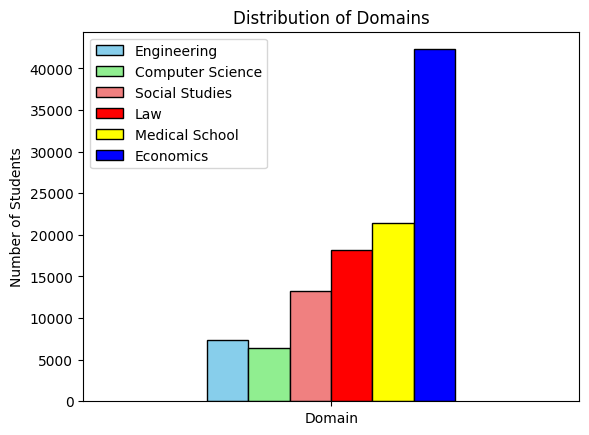

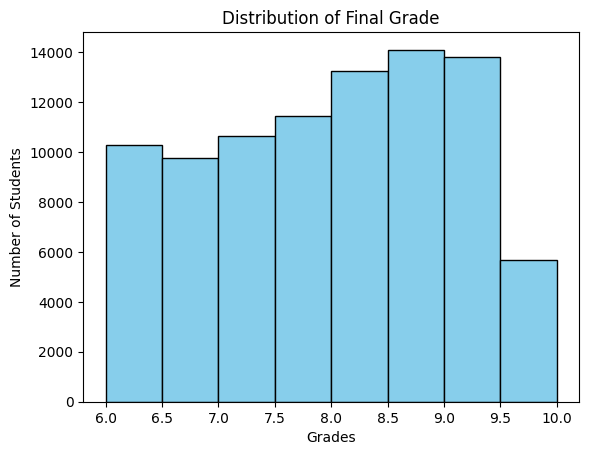

In [127]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



# Import dataset
data = []
file_path = 'bac_date-deschise_2023-ses1.csv'
file_path2 = '425220906-coduri-sirues-xls.csv'

 
# Use on_bad_lines to skip lines with too many fields
bac_data = pd.read_csv(file_path, on_bad_lines='skip')
school_data = pd.read_csv(file_path2, on_bad_lines='skip')

# bac_data = bac_data.head(2000)


# Filter data

bac_data = bac_data[bac_data['STATUS'] == 'Promovat']
columns_to_drop = ['Cod unic candidat', 'Forma de învățământ', 'Clasa', 'Subiect eb','Limba modernă','Promoție', 'Unitate (SIIIR)',
                   'NOTE_RECUN_A','NOTE_RECUN_B','NOTE_RECUN_C','NOTE_RECUN_D','NOTE_RECUN_EA','NOTE_RECUN_EB','NOTE_RECUN_EC','NOTE_RECUN_ED','STATUS_A',
                   'STATUS_B','STATUS_C','STATUS_D','STATUS_EA','STATUS_EB','STATUS_EC','STATUS_ED','ITA','SCRIS_ITC','SCRIS_PMS','ORAL_PMO','ORAL_IO',
                   'CONTESTATIE_EA','NOTA_CONTESTATIE_EA','CONTESTATIE_EB','NOTA_CONTESTATIE_EB','CONTESTATIE_EC','NOTA_CONTESTATIE_EC','CONTESTATIE_ED',
                   'NOTA_CONTESTATIE_ED','PUNCTAJ DIGITALE', 'STATUS']

columns_to_drop2 = ['Nr.', 'Fel unitate', 'Tip unitate', 'Categorie unitate', 'Limba de predare', 'Denumire', 'Forma de învăţământ']


school_data = school_data[school_data['Cod SIRUES'].isin([np.inf, -np.inf, np.nan]) == False]
school_data['Cod SIRUES'] = school_data['Cod SIRUES'].astype(int)

# remove unused columns
bac_data = bac_data.drop(columns=columns_to_drop)
school_data = school_data.drop(columns=columns_to_drop2)


# match students to their graduated school
merged_data = pd.merge(bac_data, school_data, left_on='Unitate (SIRUES)', right_on='Cod SIRUES', how='inner')
merged_data['Unitate (SIRUES)'] = merged_data['Unitate (SIRUES)'].astype(int)
# print(merged_data.head(5))


X = merged_data.drop('NOTA_EA', axis=1).drop('NOTA_EB', axis=1).drop('NOTA_EC', axis=1).drop('NOTA_ED', axis=1).drop('Medie', axis=1)  # 'target_column' is the column you want to predict
y = merged_data[['NOTA_EA', 'NOTA_EC', 'NOTA_ED']]

 
categorical_columns = ['Sex', 'Specializare', 'Profil', 'Fileira', 'Mediu candidat', 'Judeţ', 'Subiect ea', 'Subiect ec', 'Subiect ed']
one_hot_encoder = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(one_hot_encoder.fit_transform(X[categorical_columns]))
X = pd.concat([X.drop(categorical_columns, axis=1), X_encoded], axis=1)
X.columns = X.columns.astype(str)

# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
regressor.fit(X_train, y_train)
 
# Make predictions on the testing data
y_pred = regressor.predict(X_test)
 
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f"MSE:", {mse})

print(y_test.head(2))
print(regressor.predict(X_test.head(2)))


# clustering the grades
national_language_criteria = (merged_data['Subiect ea'].str.find("Limba română") != -1) & (merged_data['NOTA_EA'] >= 7)
math_criteria = (merged_data['Subiect ec'].str.find("Mate") != -1) & (merged_data['NOTA_EC'] >= 7)
history_criteria = (merged_data['Subiect ec'].str.find("Istorie") != -1) & (merged_data['NOTA_EC'] >= 7)
biology_criteria = ((merged_data['Subiect ed'].str.find("Biologie") != -1) | (merged_data['Subiect ed'].str.find("Anatomie") != -1)) & (merged_data['NOTA_ED'] >= 7)
chemistry_criteria = (merged_data['Subiect ed'].str.find("Chimie") != -1) & (merged_data['NOTA_ED'] >= 7)
geography_criteria = (merged_data['Subiect ed'].str.find("Geografie") != -1) & (merged_data['NOTA_ED'] >= 7)
physics_criteria = (merged_data['Subiect ed'].str.find("Fizică") != -1) & (merged_data['NOTA_ED'] >= 7)
economy_criteria = (merged_data['Subiect ed'].str.find("Economie") != -1) & (merged_data['NOTA_ED'] >= 7)
logic_criteria = (merged_data['Subiect ed'].str.find("Logică") != -1) & (merged_data['NOTA_ED'] >= 7)
psychology_criteria = (merged_data['Subiect ed'].str.find("Psihologie") != -1) & (merged_data['NOTA_ED'] >= 7)
informatics_criteria = (merged_data['Subiect ed'].str.find("Informatică") != -1) & (merged_data['NOTA_ED'] >= 7)

# engineering
engineering = math_criteria & (physics_criteria | chemistry_criteria)

# computer science
computer_science = math_criteria & informatics_criteria

# social_studies
social_studies = national_language_criteria & (logic_criteria | psychology_criteria)

# law
law = national_language_criteria & history_criteria

# medical school
medical_school = biology_criteria | chemistry_criteria

# economics
economics = economy_criteria | math_criteria



# Plot the distribution of categories
categories_df = pd.DataFrame({
    'Engineering': engineering.sum(),
    'Computer Science': computer_science.sum(),
    'Social Studies': social_studies.sum(),
    'Law': law.sum(),
    'Medical School': medical_school.sum(),
    'Economics': economics.sum(),
}, index=['Domain'])
categories_df.plot(kind='bar', color=['skyblue', 'lightgreen', 'lightcoral', 'red', 'yellow', 'blue'], edgecolor='black', rot=0)

# Add labels and title
# plt.xlabel('Domain')
plt.ylabel('Number of Students')
plt.title('Distribution of Domains')

# Show the plot
plt.show()


# Plot the distribution of grades using a histogram
grades = merged_data['Medie']
plt.hist(grades, bins=8, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Grades')
plt.ylabel('Number of Students')
plt.title('Distribution of Final Grade')

# Show the plot
plt.show()
